## Student Id- 23242949
## Name: Jitendra Upadhyay

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

#### There are 1337 rows and 7 columns

In [4]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [5]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [6]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [7]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

#### There are no missing values

There are no missing values. Let's check the boxplots of the numerical columns for outliers.

In [8]:
df.describe()
#df.loc[:,:].describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

<Axes: >

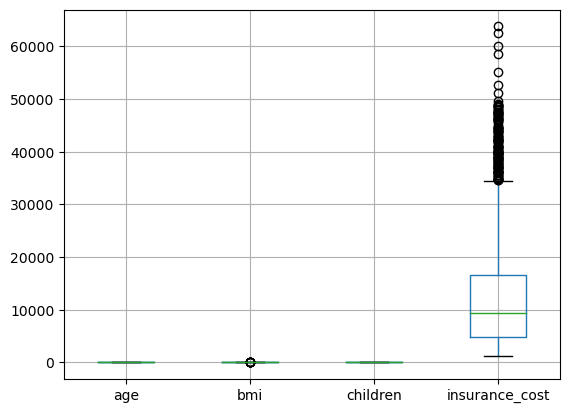

In [9]:
df.boxplot()

#### The above plots are not readable, lets look at them separately

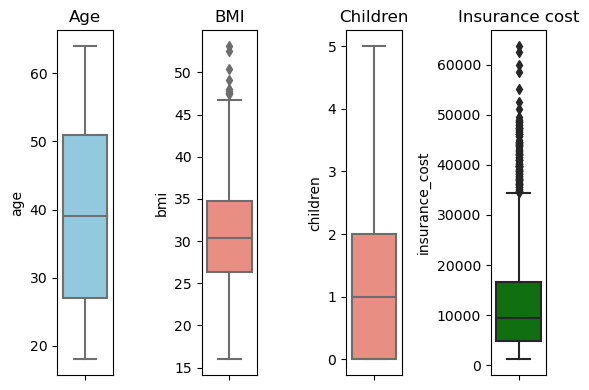

In [10]:
import seaborn as sns
# Box plots for numerical attributes
plt.figure(figsize=(10, 4))

# Box plot for 'age'
plt.subplot(1, 7, 1)
sns.boxplot(y='age', data=df, color='skyblue')
plt.title('Age')

# Box plot for 'bmi'
plt.subplot(1, 7, 2)
sns.boxplot(y='bmi', data=df, color='salmon')
plt.title('BMI')

# Box plot for 'children'
plt.subplot(1, 7, 3)
sns.boxplot(y='children', data=df, color='salmon')
plt.title('Children')

# Box plot for 'insurance_cost'
plt.subplot(1, 7, 4)
sns.boxplot(y='insurance_cost', data=df, color='green')
plt.title('Insurance cost')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


#### BMI and Duration have outliers, we will try RobustScaler to them

Let's also examine the histograms of all attribtes.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'insurance_cost'}>]], dtype=object)

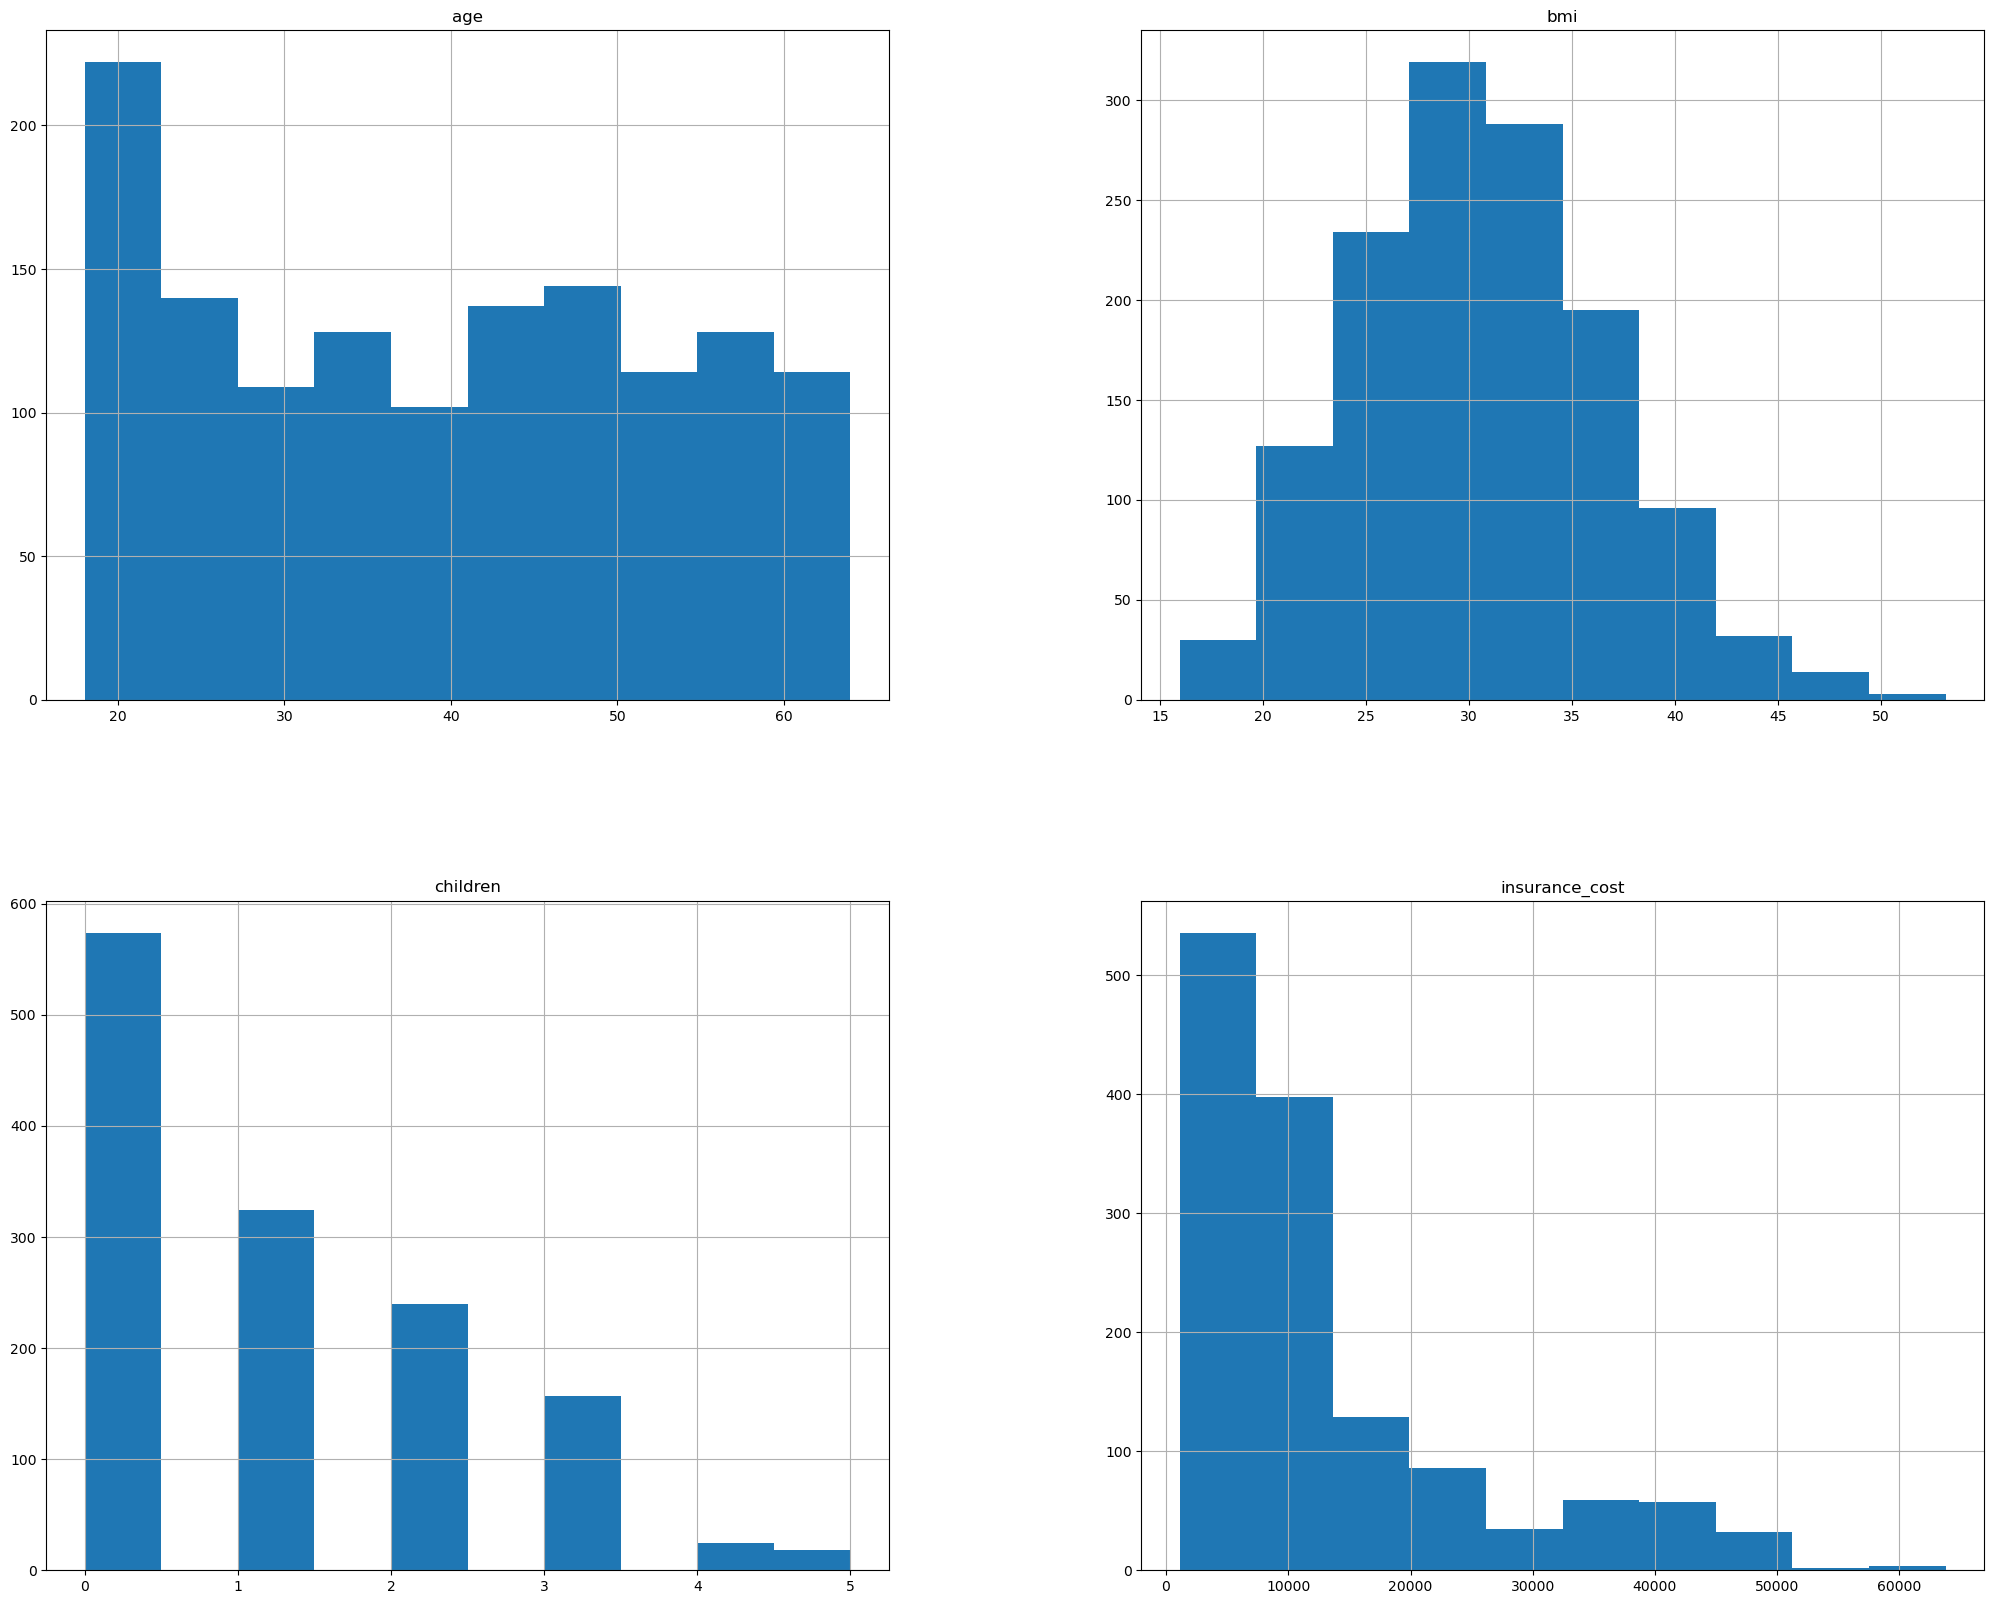

In [11]:
df.hist(bins=10, figsize=(25, 20))

In [12]:
# Calculate skewness for specific columns
skewness_age = df['age'].skew()
skewness_bmi = df['bmi'].skew()
skewness_children = df['children'].skew()
skewness_insurance_cost = df['insurance_cost'].skew()

# Print the skewness for each column
print("Skewness for Age:", skewness_age)
print("Skewness for BMI:", skewness_bmi)
print("Skewness for Children:", skewness_children)
print("Skewness for Insurance Cost:", skewness_insurance_cost)


Skewness for Age: 0.05567251565299176
Skewness for BMI: 0.2840471105987448
Skewness for Children: 0.9383804401702414
Skewness for Insurance Cost: 1.5158796580240386


Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. If the skewness is positive, it means that the right tail, the distribution has a few very large values, which can result in a longer right tail. If the skewness is negative, it means that the left tail (smaller values) of the distribution is longer or fatter than the right tail.A skewness value close to zero indicates that the distribution is approximately symmetric.

### Part of the question
First of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. 

## Data Preparation

First, we transform the `insurance_cost` column to binary.

In [13]:
# Calculate the median insurance cost
median_cost = df['insurance_cost'].median()
print(median_cost)
# Create the binary column
df['insurance_cost_binary'] = (df['insurance_cost'] > median_cost).astype(int)


df.drop(columns=['insurance_cost'], inplace=True)

9382.033


In [14]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

In [15]:
df['insurance_cost_binary'].value_counts()

0    669
1    669
Name: insurance_cost_binary, dtype: int64

##### This is evenly distributed for insurance_cost_binary.

## Model Training

### SVM

In [16]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

In [17]:
#bmi outlier. gender,smoker,region categorical.'age','children','insurance_cost_binary' pass through

In [18]:
 #group 1
categorical_columns = ['gender', 'smoker', 'region']

#group 2
numeric_columns_outliers = ['bmi']

#group 2. These will be passed through
other_columns = ['age','children']

In [19]:
# region, gender, smoker
categorical_pipeline = Pipeline(
    steps = [
        ('encoder', OneHotEncoder(drop='first', sparse_output=False))
    ]
)
numeric_columns_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)), 
        ("scaler", RobustScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ('numeric_columns_outliers', numeric_columns_pipeline, numeric_columns_outliers),
        ('categorical_columns', categorical_pipeline, categorical_columns)
    ],
    remainder='passthrough' # note there are no remaining columns in this example
).set_output(transform='pandas') 

C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [20]:
X_transformed = preprocess_pipeline.fit_transform(X);
X_transformed.head()

numeric_columns_outliers__bmi  categorical_columns__gender_male  \
0                       0.379349                               1.0   
1                       0.414439                               1.0   
2                      -0.520701                               0.0   
3                       0.867785                               0.0   
4                       0.572306                               0.0   

   categorical_columns__smoker_yes  categorical_columns__region_northwest  \
0                              0.0                                    0.0   
1                              0.0                                    0.0   
2                              0.0                                    0.0   
3                              0.0                                    0.0   
4                              0.0                                    0.0   

   categorical_columns__region_southeast  \
0                                    1.0   
1                                    1.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   categorical_columns__region_southwest  remainder__age  remainder__children  
0                                    0.0              18                    1  
1                                    0.0              18                    0  
2                                    0.0              18                    0  
3                                    0.0              18                    2  
4                                    0.0              18                    0

In [21]:
set_config(display='diagram')
display(preprocess_pipeline)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric_columns_outliers',
                                 Pipeline(steps=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('scaler', RobustScaler())]),
                                 ['bmi']),
                                ('categorical_columns',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['gender', 'smoker', 'region'])])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [23]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('svm', svm.SVC(probability=True))
])

In [24]:
# Define the parameter grid for SVM hyperparameters for 'rbf' kernel
param_grid_rbf = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
}

# Define the parameter grid for SVM hyperparameters for 'linear' kernel
param_grid_linear = {
    'svm__C': [0.1, 1, 10, 100],
}

# Define the parameter grid for SVM hyperparameters for 'poly' kernel
param_grid_poly = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__degree': [2, 3, 4],
}

In [25]:
# Use GridSearchCV with the pipeline 'pipe' and parameter grids for each kernel
search_rbf = GridSearchCV(pipe, param_grid_rbf, n_jobs=-1, cv=5, refit=True)
search_rbf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_columns_outliers',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<ufunc 'log'>)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['bmi']),
                                                                        ('categorical_columns',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['gender',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': [1, 0.1, 0.01, 0.001]})

In [26]:
search_linear = GridSearchCV(pipe, param_grid_linear, n_jobs=-1, cv=5, refit=True)
search_linear.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_columns_outliers',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<ufunc 'log'>)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['bmi']),
                                                                        ('categorical_columns',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['gender',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1, param_grid={'svm__C': [0.1, 1, 10, 100]})

In [27]:
search_poly = GridSearchCV(pipe, param_grid_poly, n_jobs=-1, cv=5, refit=True)
search_poly.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_columns_outliers',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<ufunc 'log'>)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['bmi']),
                                                                        ('categorical_columns',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['gender',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100], 'svm__degree': [2, 3, 4]})

In [28]:
# Print the best scores and parameters for each kernel
print("Best CV score (RBF kernel) = %0.3f:" % search_rbf.best_score_)
print("Best parameters (RBF kernel): ", search_rbf.best_params_)

print("Best CV score (Linear kernel) = %0.3f:" % search_linear.best_score_)
print("Best parameters (Linear kernel): ", search_linear.best_params_)

print("Best CV score (Poly kernel) = %0.3f:" % search_poly.best_score_)
print("Best parameters (Poly kernel): ", search_poly.best_params_)

Best CV score (RBF kernel) = 0.949:
Best parameters (RBF kernel):  {'svm__C': 100, 'svm__gamma': 0.01}
Best CV score (Linear kernel) = 0.934:
Best parameters (Linear kernel):  {'svm__C': 100}
Best CV score (Poly kernel) = 0.934:
Best parameters (Poly kernel):  {'svm__C': 100, 'svm__degree': 2}


In [29]:
# Store the best models
SVM_best_model_rbf = search_rbf.best_estimator_
SVM_best_model_linear = search_linear.best_estimator_
SVM_best_model_poly = search_poly.best_estimator_

##### The best CV score is 0.949 for RBF kernel and best corresponding parameters:{'svm__C': 100, 'svm__gamma': 0.01}

### Random Forest

Let's repeat the same experiment but with the Random Forest classifier.

In [32]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

Let's visualise the main pipeline.

In [33]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_columns_outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('categorical_columns',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('rf', RandomForestClassifier())])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. Random Forest.

In [34]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.933:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


KNN Model Evaluation:
Accuracy: 0.8768656716417911
Precision: 0.963302752293578
Recall: 0.7835820895522388
F1 Score: 0.8641975308641976
AUC Score: 0.9328915125863222


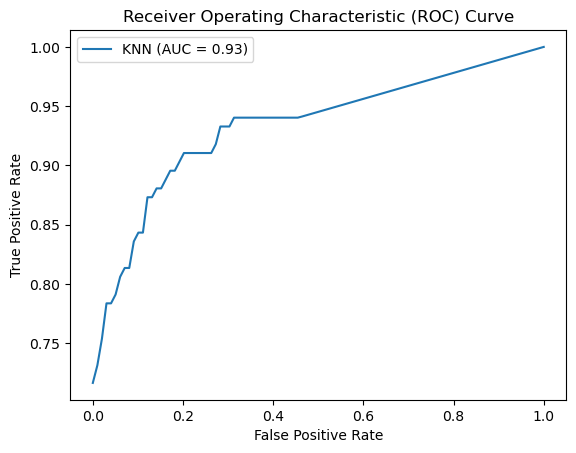

In [47]:
from sklearn.neighbors import KNeighborsClassifier

# Define the KNN classifier
knn_classifier = KNeighborsClassifier()

# Define the parameter grid for KNN hyperparameters
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'knn__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'knn__p': [1, 2]  # Power parameter for the Minkowski distance metric
}

# Update the pipeline to include KNN classifier
pipe.steps[-1] = ('knn', knn_classifier)

# Use GridSearchCV with the updated pipeline and parameter grid for KNN
search_knn = GridSearchCV(pipe, param_grid_knn, n_jobs=-1, cv=5, refit=True)
search_knn.fit(X_train, y_train)

# Evaluate the best KNN model directly
knn_accuracy, knn_precision, knn_recall, knn_f1_score, knn_tpr_transformed, knn_auc_score = evaluate_model(X_test, y_test, search_knn.best_estimator_)

# Print or store the evaluation metrics for the KNN model
print("KNN Model Evaluation:")
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1 Score:", knn_f1_score)
print("AUC Score:", knn_auc_score)

# Plot ROC curve for the KNN model
plt.plot(mean_fpr, knn_tpr_transformed.T, label='KNN (AUC = %0.2f)' % knn_auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()


## Compare Classification Models on Test Set

Now we will evaluate the best models found by grid search on test dataset and compare their results to choose better classifier. The metrics to look for are: 
- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)


In [35]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [36]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [48]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model_rbf)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
knn_accuracy, knn_precision, knn_recall, knn_f1_score, knn_tpr, knn_auc = evaluate_model(X_test, y_test, search_knn.best_estimator_)

We use a Pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

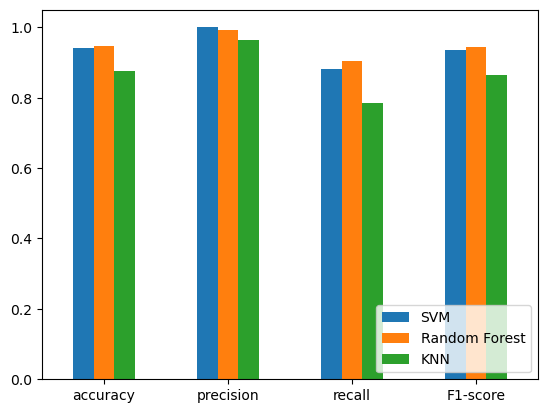

In [51]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
knn_metrics = np.array([knn_accuracy, knn_precision, knn_recall, knn_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'KNN': knn_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

SVM and RF classification models perform well. SVM has slightly better precision but RF is better on accuracy, recall and F1-score. KNN performs poorly than other two.

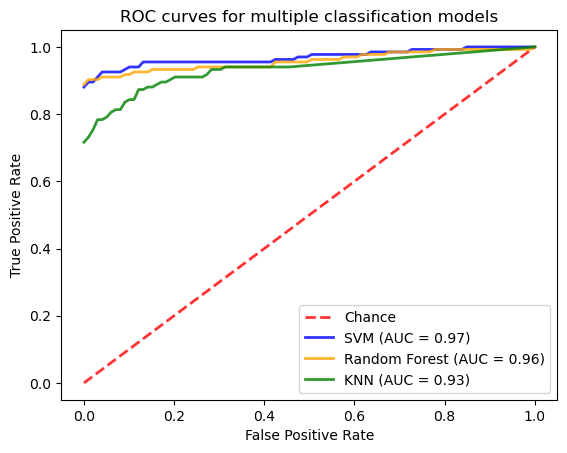

In [52]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, knn_tpr_transformed[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (knn_auc_score), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

## Train the Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [59]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform_svm(dict):
    return {key.replace('svm__', ''): value for key, value in dict.items() if key.startswith('svm__')}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(RF_best_params)))

final_model =pipe.fit(X, y)

TypeError: SVC.__init__() got an unexpected keyword argument 'rf__max_depth'